In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Polynomial regression - Model selection with k-fold cross-validation

### Selecting model-order and Generating data
Here we will generate a synthetic dataset from a n-th order polynomial model **$y = \theta_0  + \theta_1 \cdot u^1 + ... + \theta_n \cdot u^n $** and add some noise, with known distribution, to simulate sampling of the data, giving us **$y_{measured} = y + noise$**,  where:  
$y$ = output  
$u$ = input    
$\theta_{0,1,...,n}$ = model parameters   
$noise$ = measurement noise

Given the genreated input data $u$ and the measured data **$y_{measured}$** we will try to estimate the polynomial model coeffitienst $\hat{\theta}_{0,1,...,n}$ using the Least sqaures (LS) and Maximum likelihood estimate (MLE) methods.

### Model-order selection 
The "params" vector decides the order of the selected model, make sure to put in \$n+1\$ parameters into the vector for the get a model of order \$n\$, the first parameter \$\theta_0\$ is the bias term

In [13]:
def arbitrary_poly(params):
    poly_model = lambda x: sum([p*(x**i) for i, p in enumerate(params)])
    return poly_model

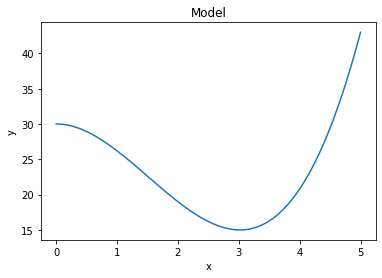

In [14]:
# params: [theta_0, theta_1, ... , theta_n], where n = model order and theta_0 is bias 
true_params = [30,0.1,-5,1.1]
y_model = arbitrary_poly(true_params)

# Plot true model
x = np.linspace(start=0, stop=5, num=100)
plt.figure()
plt.plot(x, y_model(x))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Model");

### Measurement noise generation from a chosen distribution
Probability density functions (PDFs):

Gaussian pdf: $P(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$

Laplacian pdf: $P(x) = \frac{1}{2b}e^{-\frac{|x-\mu|}{b}}$

Hyperparameters to adjust:
- dist: "laplace" or "gauss" : the class of noise-generating distribution.
- mu: The distribution's location parameter (mean value for Gauss).
- sigma: The distribution's scaling parameter (std. for Gauss).
- magnitude: The noise magnitude.
- N: number of samples to generate for the model.

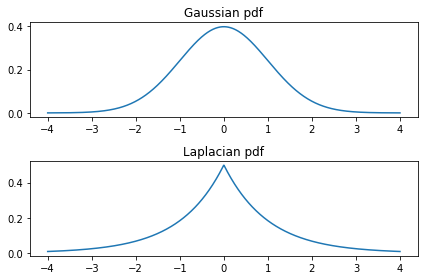

In [15]:
# Hyperparameters for the type of noise-generating distribution.
dist = "laplace"  # choose between "laplace" or "gauss"
loc = 0           # location (mean) parameter 
scale = 1         # scaling (std dev) parameter
magnitude = 1.4   # noise magnitude
N = 200           # number of samples

np.random.seed(123)  # Non-random generation between code executions. Comment out for true random

# The Laplace probability density function:
# Also available in library "scipy.stats.laplace"
def laplace_pdf(x, loc, scale):
    return (1.0/(2.0 * scale)) * np.exp( -np.abs(x-loc) / scale)

# The Gaussian probability density function:
# Also available in library "scipy.stats.norm"
def gauss_pdf(x, loc, scale):
    return 1.0/(scale * np.sqrt(2.0 * np.pi)) * np.exp( -0.5 * ((x - loc) / scale)**2 )

# Plot pdfs:
fig, [ax0, ax1] = plt.subplots(2)

n = np.linspace(start=(loc - 4*scale), stop=(loc + 4*scale), num=1000)  # input range centered around mean of pdf
ax0.plot(n, gauss_pdf(n, loc, scale))
ax0.set_title('Gaussian pdf')
ax1.plot(n,laplace_pdf(n, loc, scale))
ax1.set_title('Laplacian pdf')
plt.tight_layout()
plt.show()

### Data generation:

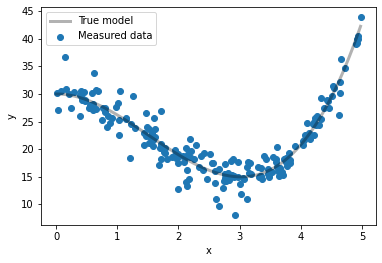

In [16]:
# Generate data points
range_start = 0
range_end = 5
u = np.sort(np.random.uniform(range_start,range_end,N))
y_true = y_model(u)

# Generate noise
from scipy.stats import norm, laplace
if dist == "laplace":
    #pdf = laplace_pdf
    pdf = laplace.pdf
    noise = magnitude * np.random.laplace(loc, scale, N)
elif dist == "gauss":
    #pdf = gauss_pdf
    pdf = norm.pdf
    noise = magnitude * np.random.normal(loc, scale, N)
else:
    raise Exception("Distribution not implemented, choose \"laplace\" or \"gauss\"")

# Add noise to the generated data points - thus simulating measurement
y = y_true + noise

# Plot measured data
plt.scatter(u, y, label=r"Measured data")
u0 = np.linspace(0, max(u), N)
plt.plot(u0, y_model(u0), "k", alpha=0.3, lw=3, label="True model")
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

In [17]:
import scipy.optimize as optimize

def log_lik(par_vec, y, x):
    global pdf  # Use the distribution class chosen earlier
    # If the standard deviation parameter is negative, return a large value:
    if par_vec[-1] < 0:
        return(1e8)
    # The likelihood function values:
    lik = pdf(y,
              loc = sum([p*(x**i) for i, p in enumerate(par_vec[:-1])]),
              scale = par_vec[-1])
    
    #This is similar to calculating the likelihood for Y - XB
    # res = y - par_vec[0] - par_vec[1] * x
    # lik = norm.pdf(res, loc = 0, sd = par_vec[2])
    
    # If all logarithms are zero, return a large value
    if all(v == 0 for v in lik):
        return(1e8)
    # Logarithm of zero = -Inf
    return(-sum(np.log(lik[np.nonzero(lik)])))

def MLE_estimate(measured_data, input_data, model_order, num_samples):
    # The likelihood function includes the scale (std dev) parameter which is also estimated by the optimized
    # therefore the initial guess verctor has length n+2 [theta_0_hat, theta_1_hat, ... , theta_n_hat, sigma_hat]
    init_guess = np.zeros(model_order+1)
    init_guess[-1] = num_samples

    # Do Maximum Likelihood Estimation:
    opt_res = optimize.minimize(fun = log_lik,
                                x0 = init_guess,
                                #options={'disp': True},
                                args = (measured_data, input_data))

    MLE_params = opt_res.x[:-1]
    #MLE_model = arbitrary_poly(MLE_params)
    
    return MLE_params

def LS_estimate(measured_data, input_data, model_order, num_samples):
    # Step 1
    # Matrix form
    u_tensor_0 = np.reshape(input_data,(num_samples,1))
    ones_vec = np.ones((num_samples,1))
    u_tensor = np.append(ones_vec, u_tensor_0, axis=1)

    for i in range(2,model_order):
        u_tensor = np.append(u_tensor, np.power(u_tensor_0, i) ,axis=1)
    
    # Step 2
    u_transpose_dot_u = np.dot(u_tensor.T,u_tensor)  # calculating dot product
    u_transpose_dot_u_inv = np.linalg.inv(u_transpose_dot_u) #calculating inverse
    
    # Step 3
    u_transpose_dot_y = np.dot(u_tensor.T, measured_data)  # calculating dot product
    
    # Step 4
    LS_params = np.dot(u_transpose_dot_u_inv,u_transpose_dot_y)

    # Recreate model based on LS estimate:
    LS_params = LS_params.tolist()
    #LS_model = arbitrary_poly(LS_params)
    
    return LS_params

## k-fold Cross-Validation
k-fold Cross-Validation is the preferred method for model validation (hyperparameter selection) when the available
data is limited and you cannot afford to split the data into separate train/test/validate sets.

In k-fold CV, the training data is split evenly into $k$ parts, or folds, where one of the folds are withheld as a validation set, and the remaining folds are used to fit the model.
After fitting the model, the withheld validation data is used to evaluate the fitted model's performance using some metric, in this case: RMSE.
Then, this process is repeated until each and every fold of the data has been used both for training and validation.
That is, we fit the model $k$ times, and each time we evaluate it using a unique validation set.

This way, we can utilize all of the data for training and validating the model while still get some understanding for whether the model is generalizing consistently.
k-fold CV is therefore often used for hyperparameter tuning, such as selecting the polynomial order for our fitted model.

By cross-validating the models' performance for an increasing polynomial order, we can determine the best fit by analysing the training and validation RMSE.

In [18]:
from sklearn.model_selection import KFold, train_test_split

def cross_validate(method, X, y, model_order=2, n_splits=5):
    # Set up the K-fold splitting function and choose number of folds (5-10 is recommended)
    kf = KFold(n_splits=n_splits,shuffle=True, random_state=5)

    # RMSE will be used to evaluate the methods' performance on training, validation and test data.
    RMSE = dict()
    RMSE_train = np.array([])
    RMSE_val = np.array([])

    # K-fold slicing loop: Fit a model to k different folds of training data and validate.
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        fitted_model = method(measured_data=y_train,
                              input_data=X_train,
                              model_order=model_order,
                              num_samples=len(X_train))

        # Approximate model fitted to this fold
        sub_model = arbitrary_poly(fitted_model)

        # Calculate the avg. RMSE of the sub-model
        _RMSE_train = np.sqrt(np.mean((sub_model(X_train)-y_train)**2))
        _RMSE_val   = np.sqrt(np.mean((sub_model(X_val)-y_val)**2))

        # For increasing model order complexity, it can be beneficial to plot training vs. validation performance
        # to see when the model starts to overfit the training data.
        RMSE_train = np.append(RMSE_train, _RMSE_train)
        RMSE_val   = np.append(RMSE_val, _RMSE_val)


    # Calculate the avg & std of RMSE
    RMSE["train"] = RMSE_train
    RMSE["val"]   = RMSE_val
    #print("Average k-fold cross-validation RMSE for ", method.__name__, " with ", model_order,"-order model:", sep="")
    #print("Training data: [%.3f] +/- [%.3f]" % (RMSE_train.mean(), RMSE_train.std()))
    #print("Validation data: [%.3f] +/- [%.3f]" % (RMSE_val.mean(), RMSE_val.std()))

    return RMSE

def test_model(method, X_train, y_train, X_test, y_test, model_order):
    model_params = method(measured_data=y_train,
                          input_data=X_train,
                          model_order=model_order,
                          num_samples=len(X_train))
    
    # Fit the model using the train set and test it using the test set data    
    fitted_model = arbitrary_poly(model_params)
    RMSE_test = np.sqrt(np.mean((fitted_model(X_test)-y_test)**2))

    return RMSE_test

### Splitting the data and the cross-validation calculation loop
Since we can generate as much data as we want from our model, we can afford to withhold an additional test set to evaluate our final model.
The test set represents unseen/future data that the model will encounter after we have concluded the model selection and applied the model in the real world.
This is good practice, as it ensures that the final evaluation isn't fine tuned to the training data, thus providing a more realistic representation of how the fitted model will perform.

First, we split the data into training and test data. The cross-validation method inherently takes care of splitting into $k$ folds of training and validation data, but we'll withhold the additional test set.



In [28]:
# Split the data into training and test sets.
u_train, u_test, y_train, y_test = train_test_split(u, y, test_size=0.2, random_state=5)

# Make an educated guess for the range in which the true polynomial model lies.
min_order = 2
max_order = 8
order_guesses = np.arange(min_order, max_order+1, dtype="int")

# Select number of folds for cross-validation:
k = 5

# Containers for the different order models
MLE_train = []
MLE_val   = []
MLE_test  = []

LS_train = []
LS_val   = []
LS_test  = []

print("{}-fold Cross-Validation:".format(k))
for model_order in order_guesses:
    # Might take some time if many polynomial orders are explored, let's track the progress with a simple progress bar:
    print("\rProcessing {}th-order model (of {})".format(model_order, order_guesses[-1]), end="", flush=True)

    # Do Cross-Validation -> get training and validation RMSE
    MLE_RMSE = cross_validate(MLE_estimate, u_train, y_train, model_order=model_order, n_splits=k)
    LS_RMSE = cross_validate(LS_estimate, u_train, y_train, model_order=model_order, n_splits=k)
    
    # Calculate the test-set RMSE
    MLE_RMSE_test = test_model(MLE_estimate, u_train, y_train, u_test, y_test, model_order)
    LS_RMSE_test  = test_model(LS_estimate, u_train, y_train, u_test, y_test, model_order)
    
    # Store the results
    LS_train.append(np.mean(LS_RMSE["train"]))
    LS_val.append(LS_RMSE["val"].mean())
    LS_test.append(LS_RMSE_test)
    MLE_train.append(np.mean(MLE_RMSE["train"]))
    MLE_val.append(MLE_RMSE["val"].mean())
    MLE_test.append(MLE_RMSE_test)

5-fold Cross-Validation:
Processing 8th-order model (of 8)

## Analysis of the results
Plotting the training and validation performance from cross-validation can help choose the best fit for the available data.
In this case, the lower order models (2nd and 3rd order polynomials) underfit the data and gives high RMSE.

However, the cross-validation did not catch any significant overfitting in the higher-order models.
(Overfitting would have been shown as an increasing validation loss vs. a consistently low training loss)

Why is this the case?

Nevertheless, the cross-validation shows that the losses stop decreasing after fitting a polynomial of order 4, let's fit a 4th order model to all the training data and evaluate its test set / generalization performance.

(We've inlcuded the test set performance for all the model orders for illustrative purposes. However, the test set is not to be used for hyperparameter tuning.)

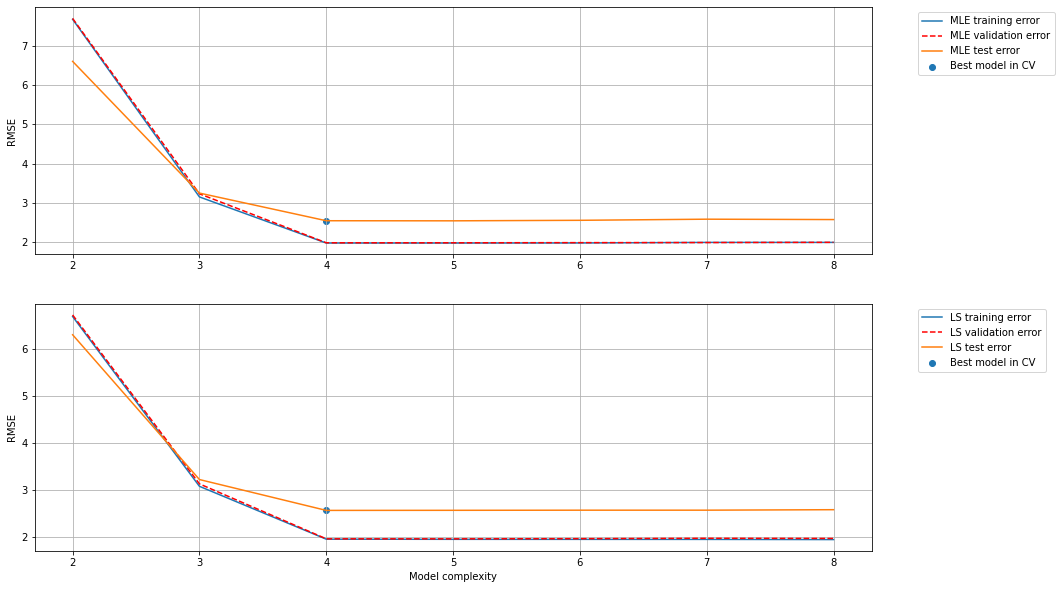

In [31]:
# Show test RMSE? (True / False)
show_test_RMSE = True

chosen_model_order = 4  # Polynomial order chosen from cross-validation.

fig, (ax0, ax1) = plt.subplots(2,figsize=(15,10))
ax0.plot(order_guesses, MLE_train, label="MLE training error")
ax0.plot(order_guesses, MLE_val, 'r--', label="MLE validation error")
ax0.set_xticks(order_guesses)
ax0.set_ylabel("RMSE")
ax1.set_ylabel("RMSE")
ax1.set_xlabel("Model complexity")
ax1.plot(order_guesses, LS_train, label="LS training error")
ax1.plot(order_guesses, LS_val, 'r--', label="LS validation error")
if show_test_RMSE:
    ax0.plot(order_guesses, MLE_test, label="MLE test error")
    ax1.plot(order_guesses, LS_test, label="LS test error")
    ax0.scatter(chosen_model_order, MLE_test[chosen_model_order-1], label="Best model in CV")
    ax1.scatter(chosen_model_order, LS_test[chosen_model_order-1], label="Best model in CV")
ax1.set_xticks(order_guesses)
ax0.legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax1.legend(loc='upper left',bbox_to_anchor=(1.05, 1))
ax0.grid()
ax1.grid()
plt.show()